In [ ]:

!git clone https://github.com/siapai/tuft-dental-segmentation.git temp
!mv temp/segmentation .
!rm -drf temp

Cloning into 'temp'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 136 (delta 52), reused 128 (delta 44), pack-reused 0
Receiving objects: 100% (136/136), 32.16 KiB | 16.08 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
!pip install -q pytorch-lightning
!pip install -q pretrainedmodels
!pip install -q torchmetrics
!pip install -q albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Ensure the destination directory exists
os.makedirs('data', exist_ok=True)

# Unzip the file
!unzip /content/drive/MyDrive/Datasets/TuftDental/Radiographs.zip -d data/
!unzip /content/drive/MyDrive/Datasets/TuftDental/Segmentation.zip -d data/

!cp /content/drive/MyDrive/Datasets/TuftDental/data_split.json .



Archive:  /content/drive/MyDrive/Datasets/TuftDental/Radiographs.zip
   creating: data/Radiographs/
  inflating: data/Radiographs/1.JPG  
  inflating: data/Radiographs/100.JPG  
  inflating: data/Radiographs/1000.JPG  
  inflating: data/Radiographs/1001.JPG  
  inflating: data/Radiographs/1002.JPG  
  inflating: data/Radiographs/1004.JPG  
  inflating: data/Radiographs/1007.JPG  
  inflating: data/Radiographs/1008.JPG  
  inflating: data/Radiographs/1009.JPG  
  inflating: data/Radiographs/101.JPG  
  inflating: data/Radiographs/1010.JPG  
  inflating: data/Radiographs/1011.JPG  
  inflating: data/Radiographs/1012.JPG  
  inflating: data/Radiographs/1013.JPG  
  inflating: data/Radiographs/1014.JPG  
  inflating: data/Radiographs/1015.JPG  
  inflating: data/Radiographs/1016.JPG  
  inflating: data/Radiographs/1017.JPG  
  inflating: data/Radiographs/1018.JPG  
  inflating: data/Radiographs/102.JPG  
  inflating: data/Radiographs/1020.JPG  
  inflating: data/Radiographs/1021.JPG  
  in

In [ ]:
import os

import torch
import torchvision
import albumentations as A

print(torch.__version__)
print(torchvision.__version__)
print(A.__version__)

2.3.0+cu121
0.18.0+cu121
1.3.1


In [ ]:
import cv2
from albumentations.pytorch import ToTensorV2


# Transformasi untuk pelatihan
safe_transforms = A.Compose([
    # Geometric Transforms
    A.Rotate(limit=3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=3, p=0.5),
    A.PadIfNeeded(min_height=640, min_width=1280, always_apply=True, border_mode=cv2.BORDER_CONSTANT),
    A.RandomResizedCrop(height=640, width=1280, scale=(0.9, 1.0), p=0.5),  # Safe Cropping with 32 multiples
    A.Resize(height=256, width=512),

    # Color and Contrast Adjustments
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),

    # Blur and Noise
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.5),

    # Distortions
    A.ElasticTransform(alpha=0.1, sigma=10, alpha_affine=10, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5),
    A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.5),

    # Other Effects
    A.CLAHE(clip_limit=1.0, p=0.5),
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.5),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.5, 1.0), p=0.5),
    A.MotionBlur(blur_limit=(3, 5), p=0.5),
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),

    # Flips
    A.HorizontalFlip(p=0.5),

    # Normalization and Conversion to Tensor
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])


val_transform = A.Compose([
    A.Resize(height=256, width=512),  # Resize to 256x512
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # Normalize image to 0-1 range
    ToTensorV2()
])

In [ ]:
import json
from torch.utils.data import Dataset
import cv2
import numpy as np

class DentalDataset(Dataset):
    def __init__(self, data_path: str, split: str, transform=None):
        with open(data_path, 'r') as f:
            self.data = json.load(f)

        self.images = self.data[split]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]['image']
        mask_path = self.images[idx]['mask']

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = self.preprocess_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].permute(2, 0, 1)

        return image, mask

    def preprocess_mask(self, mask):
        # Threshold the mask to ensure it only contains 0 and 1 values
        _, binary_mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
        binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add channel dimension
        return binary_mask

In [ ]:
train_dataset = DentalDataset(
    data_path='data_split.json',
    split='train',
    transform=safe_transforms
)

valid_dataset = DentalDataset(
    data_path='data_split.json',
    split='valid',
    transform=val_transform
)

test_dataset = DentalDataset(
    data_path='data_split.json',
    split='test',
    transform=val_transform
)

print(f'[INFO] Length of train dataset: {len(train_dataset)}')
print(f'[INFO] Length of valid dataset: {len(valid_dataset)}')
print(f'[INFO] Length of test dataset: {len(test_dataset)}')

[INFO] Length of train dataset: 700
[INFO] Length of valid dataset: 150
[INFO] Length of test dataset: 150


In [ ]:
img, msk = train_dataset[0]
(img.shape, msk.shape)

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

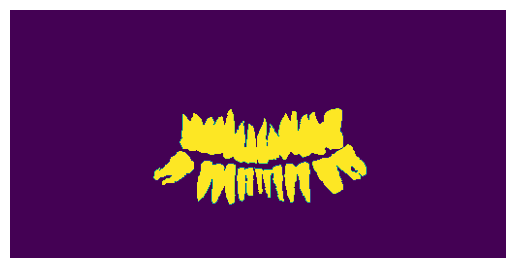

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(msk.permute(1, 2, 0))
plt.axis(False)
plt.show()

In [ ]:
import os
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

print(f'Number of Workers: {NUM_WORKERS}')
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Number of Workers: 12


In [ ]:
import random
import matplotlib.pyplot as plt

def visualize_batch(dataloader, num_images=2):
    images, masks = next(iter(dataloader))

    random_indices = random.sample(range(len(images)), num_images)

    # Plot the images and annotations side by side
    fig, axes = plt.subplots(num_images, 2, figsize=(16, 4 * num_images))

    for i, idx in enumerate(random_indices):

        image = images[i].squeeze(0).permute(1, 2, 0)
        mask = masks[i].squeeze(0)

        axes[i, 0].imshow(image, alpha=1)
        # axes[i, 0].imshow(mask, alpha=0.5)
        axes[i, 0].axis(False)

        axes[i, 1].imshow(image, alpha=0.5)
        axes[i, 1].imshow(mask, alpha=0.5)
        axes[i, 1].axis(False)

    plt.show()

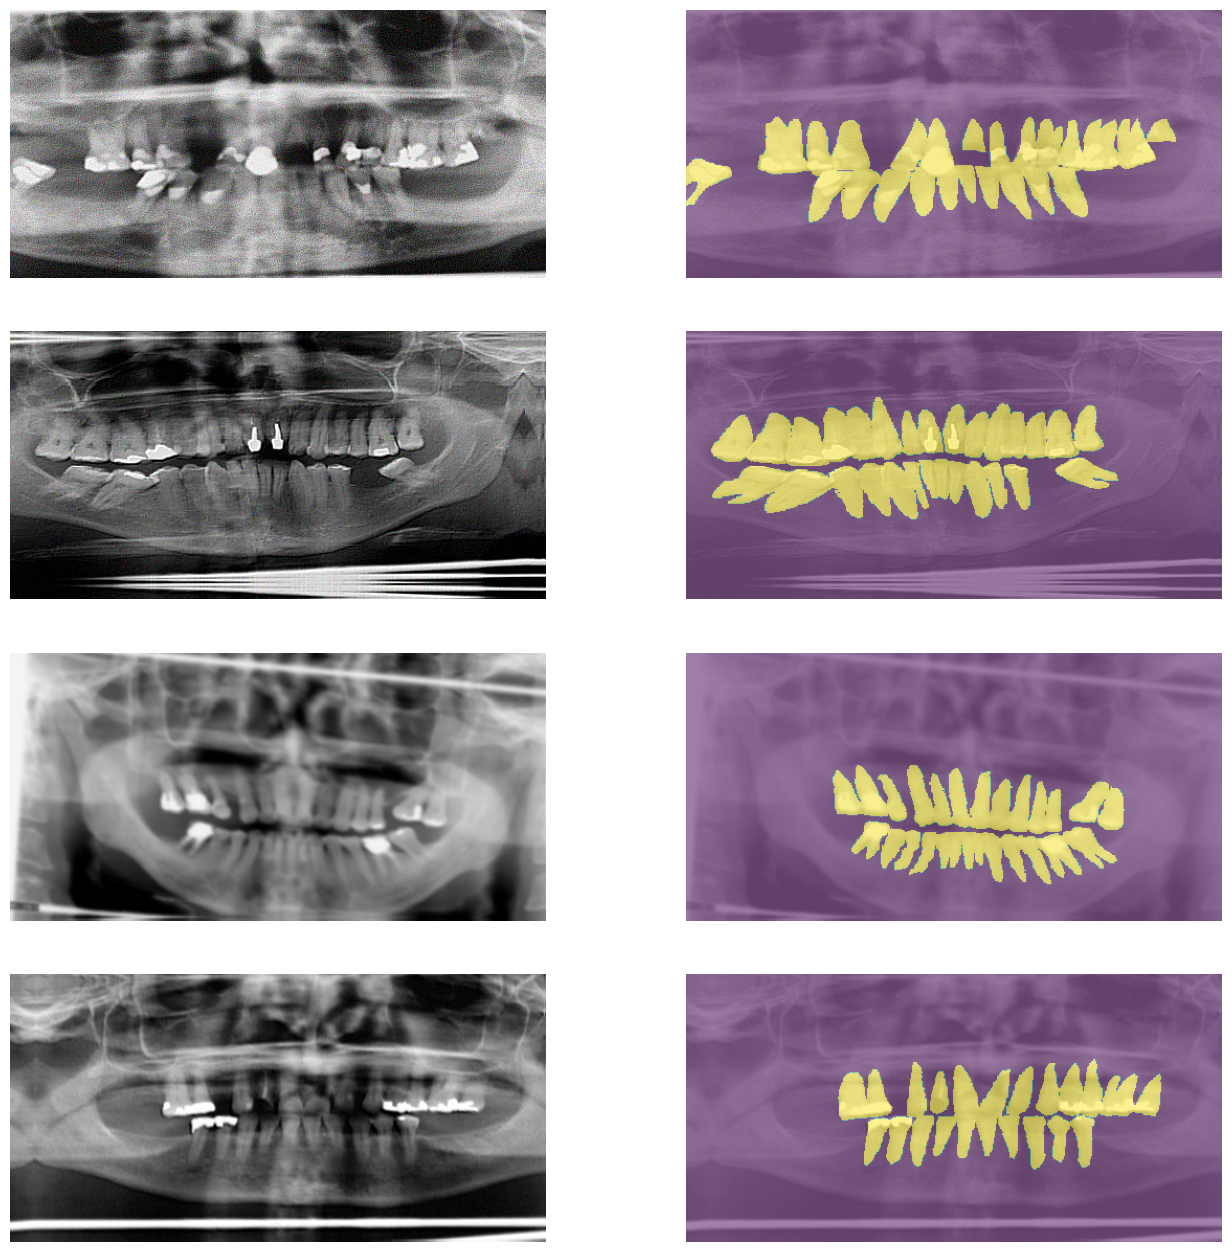

In [ ]:
visualize_batch(train_dataloader, 4)

In [ ]:
import segmentation as sm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchmetrics import JaccardIndex, Accuracy

class DentalModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = sm.create_model(
            arch=arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs
        )

        self.loss_fn = sm.losses.DiceLoss(sm.losses.BINARY_MODE, from_logits=True)

        self.iou = JaccardIndex(task='binary') # IoU
        self.accuracy = Accuracy(task='binary') # Pixel Accuracy

    def forward(self, x):
        return self.model(x)

    def _common_step(self, batch):
        image, mask = batch
        assert image.ndim ==4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        return loss, logits_mask

    def _calc_metrics(self, loss, logits_mask, target_mask, stage):
        dice = 1.0 - loss

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        iou = self.iou(pred_mask, target_mask)
        acc = self.accuracy(pred_mask, target_mask)

        if stage == 'val':
            self.logger.experiment.add_scalars('dice', {stage: dice}, self.current_epoch)
            self.logger.experiment.add_scalars('iou', {stage: iou}, self.current_epoch)
            self.logger.experiment.add_scalars('accuracy', {stage: acc}, self.current_epoch)


        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.log_dict({
            f'{stage}_dice': dice,
            f'{stage}_iou': iou,
            f'{stage}_acc': acc
        }, on_step=False, on_epoch=True)


    def training_step(self, batch, batch_idx):
        loss, _ = self._common_step(batch)
        self.logger.experiment.add_scalars('loss', {'train': loss}, self.current_epoch)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        _, target_mask = batch
        loss, logits_mask = self._common_step(batch)
        self.logger.experiment.add_scalars('loss', {'val': loss}, self.current_epoch)
        self._calc_metrics(loss, logits_mask, target_mask, "val")
        return loss

    def test_step(self, batch, batch_idx):
        _, target_mask = batch
        loss, logits_mask = self._common_step(batch)
        self._calc_metrics(loss, logits_mask, target_mask, "test")
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': plateau_scheduler,
                'monitor': 'val_loss'
            }
        }

checkpoint_cb = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best_checkpoint',
    verbose=True
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')


In [ ]:
import time
from pytorch_lightning.callbacks import Callback

class TrainingTimeLogger(Callback):
    def on_train_start(self, trainer, pl_module):
        self.train_start_time = time.time()
        print("Training started.")

    def on_train_end(self, trainer, pl_module):
        self.train_end_time = time.time()
        elapsed_time = self.train_end_time - self.train_start_time
        print(f"Training finished. Elapsed time: {elapsed_time:.2f} seconds")



In [ ]:
model = DentalModel("deeplabv3", "resnet34", in_channels=3, out_classes=1)

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

tensorboard_logger = TensorBoardLogger("/content/drive/MyDrive/Experiment/Tuft", name="deeplabv3-resnet34")
time_logger = TrainingTimeLogger()


trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=300,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_monitor, time_logger],
    logger=tensorboard_logger
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The ver

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Training started.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.382
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 22: 'val_loss' reached 0.38205 (best 0.38205), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.299
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 44: 'val_loss' reached 0.29882 (best 0.29882), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 0.210
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 66: 'val_loss' reached 0.21008 (best 0.21008), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 88: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.177
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 110: 'val_loss' reached 0.17713 (best 0.17713), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.164
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 132: 'val_loss' reached 0.16364 (best 0.16364), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.159
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 154: 'val_loss' reached 0.15880 (best 0.15880), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.156
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 176: 'val_loss' reached 0.15565 (best 0.15565), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 198: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.143
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 220: 'val_loss' reached 0.14259 (best 0.14259), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.141
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 242: 'val_loss' reached 0.14055 (best 0.14055), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.135
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 264: 'val_loss' reached 0.13538 (best 0.13538), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.129
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 286: 'val_loss' reached 0.12905 (best 0.12905), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 308: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 330: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 374: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.127
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 396: 'val_loss' reached 0.12682 (best 0.12682), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 418: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.124
INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 440: 'val_loss' reached 0.12381 (best 0.12381), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.124
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 462: 'val_loss' reached 0.12370 (best 0.12370), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 484: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 506: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.121
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 528: 'val_loss' reached 0.12131 (best 0.12131), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 572: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.121
INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 594: 'val_loss' reached 0.12063 (best 0.12063), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 616: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.120
INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 638: 'val_loss' reached 0.11954 (best 0.11954), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.119
INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 660: 'val_loss' reached 0.11888 (best 0.11888), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 682: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.118
INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 704: 'val_loss' reached 0.11783 (best 0.11783), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 726: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.116
INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 748: 'val_loss' reached 0.11615 (best 0.11615), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 770: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 792: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 814: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 836: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.115
INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 858: 'val_loss' reached 0.11458 (best 0.11458), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 902: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 924: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 946: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.114
INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 968: 'val_loss' reached 0.11387 (best 0.11387), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.113
INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 990: 'val_loss' reached 0.11332 (best 0.11332), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 1012: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 1034: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 1056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 1078: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 1122: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.109
INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 1144: 'val_loss' reached 0.10871 (best 0.10871), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 1166: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 1188: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 1210: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 1232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 1254: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.106
INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 1276: 'val_loss' reached 0.10572 (best 0.10572), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 1298: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 1320: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 1342: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 1364: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 1386: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 1408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.104
INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 1430: 'val_loss' reached 0.10444 (best 0.10444), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 1452: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 1474: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 1496: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 1518: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 1540: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 1562: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 1584: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 1606: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 1628: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 1672: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 1694: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.104
INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 1716: 'val_loss' reached 0.10386 (best 0.10386), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 1738: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 1760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 1782: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 1804: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 1826: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 1848: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.104
INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 1870: 'val_loss' reached 0.10353 (best 0.10353), saving model to '/content/drive/MyDrive/Experiment/Tuft/deeplabv3-resnet34/version_0/checkpoints/best_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 1892: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 1914: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 1936: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 1958: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 1980: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 2002: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 2024: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 2046: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 2068: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 2090: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 2112: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 2134: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 2156: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 2178: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 2222: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 2244: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 2266: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 2288: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 20 records. Best score: 0.104. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 2310: 'val_loss' was not in top 1


Training finished. Elapsed time: 2717.75 seconds


In [ ]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'val_loss': 0.10383815318346024, 'val_dice': 0.8961619138717651, 'val_iou': 0.813386857509613, 'val_acc': 0.9748250246047974}]


In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.10678844153881073, 'test_dice': 0.8932114839553833, 'test_iou': 0.8085638284683228, 'test_acc': 0.9746705889701843}]


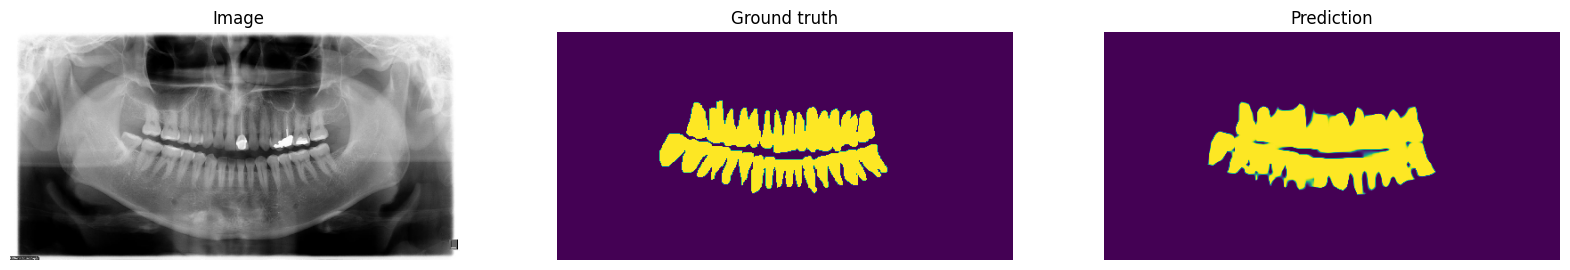

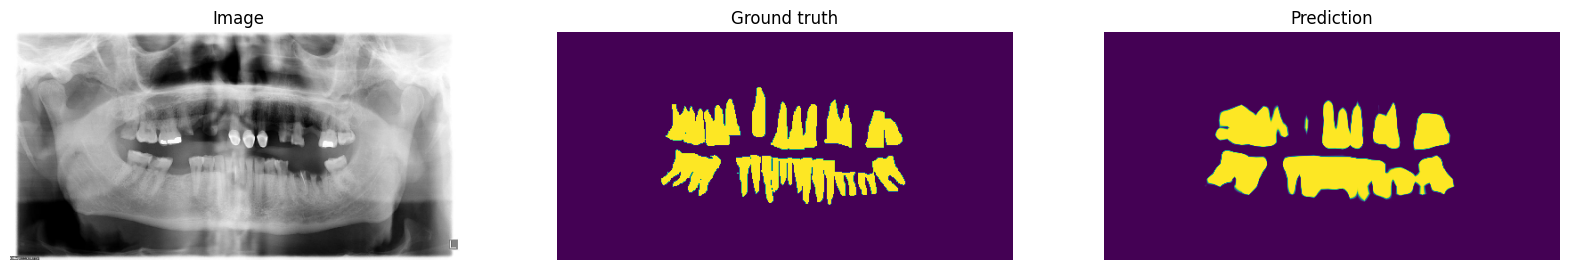

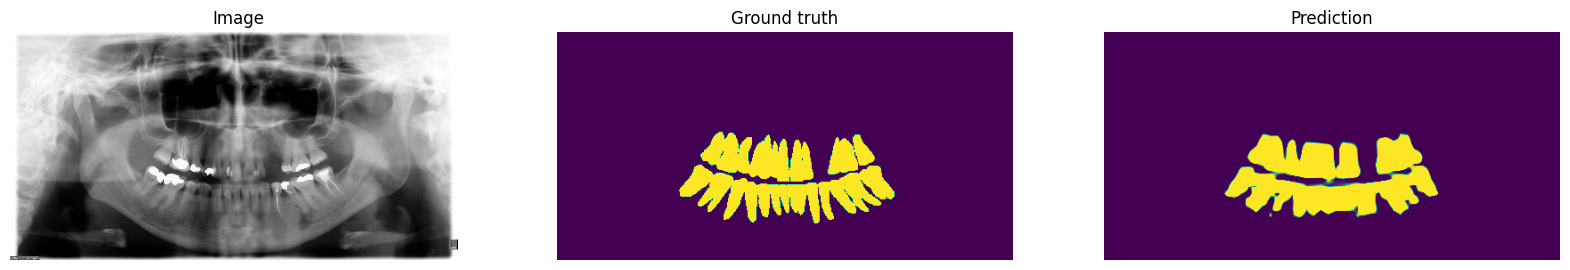

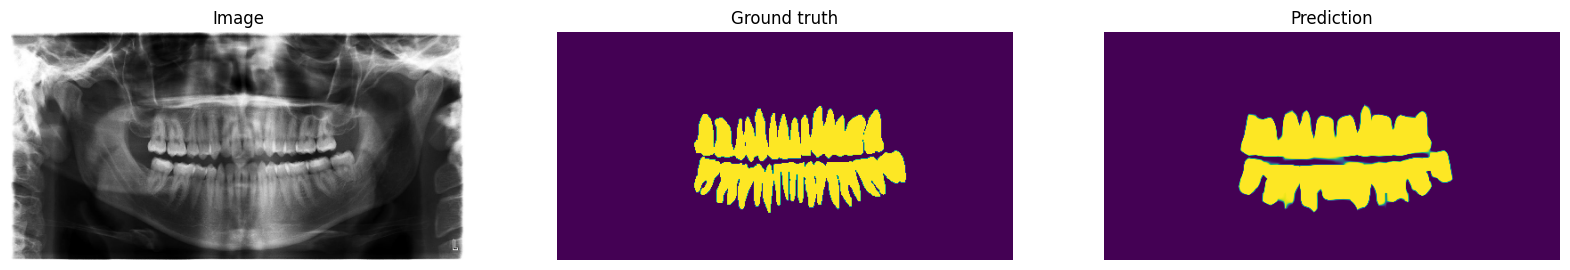

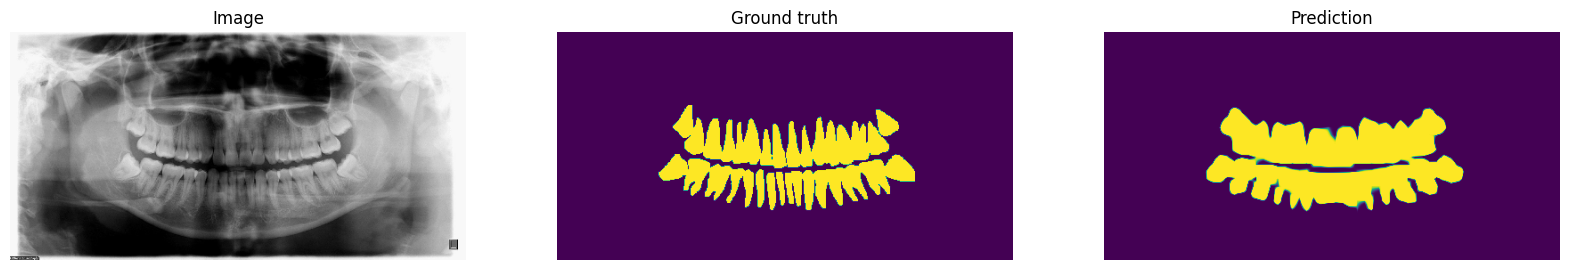

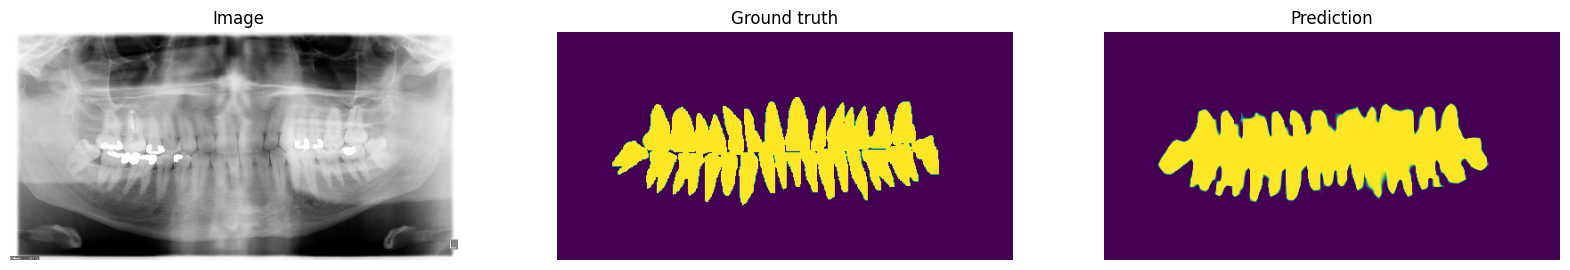

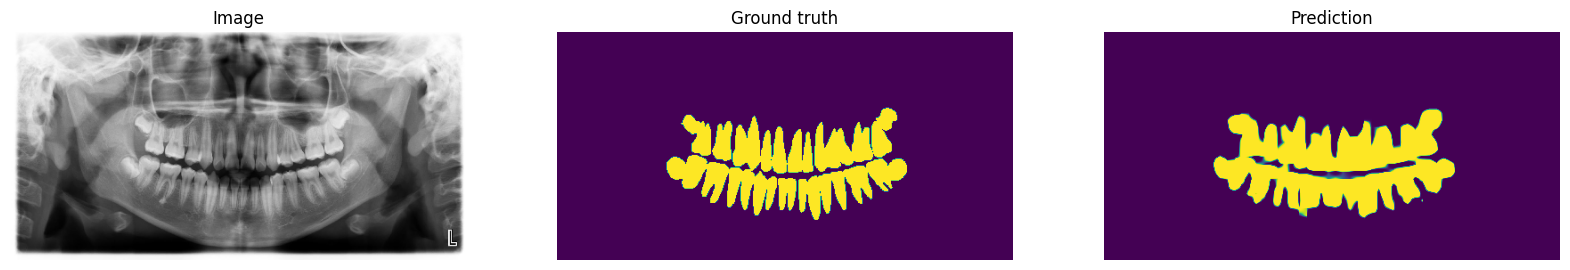

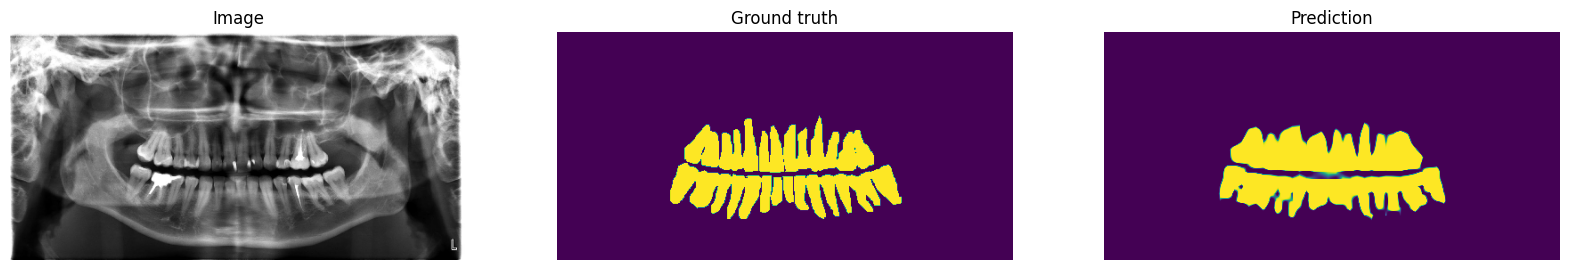

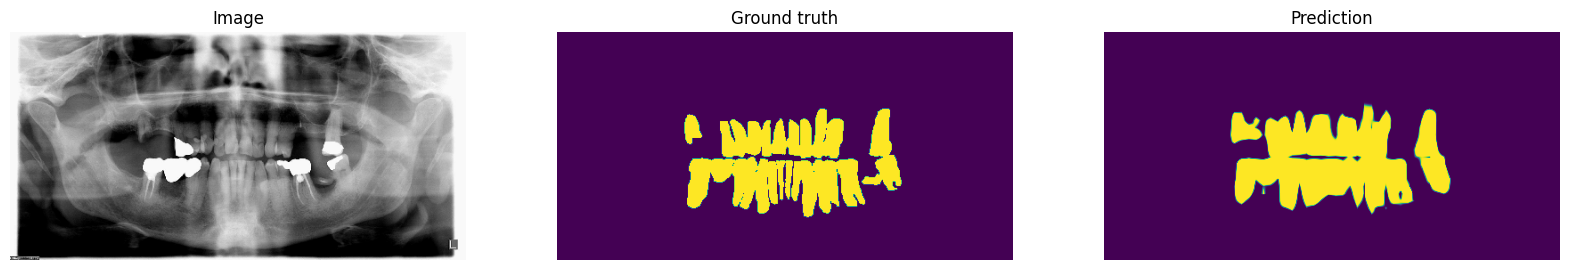

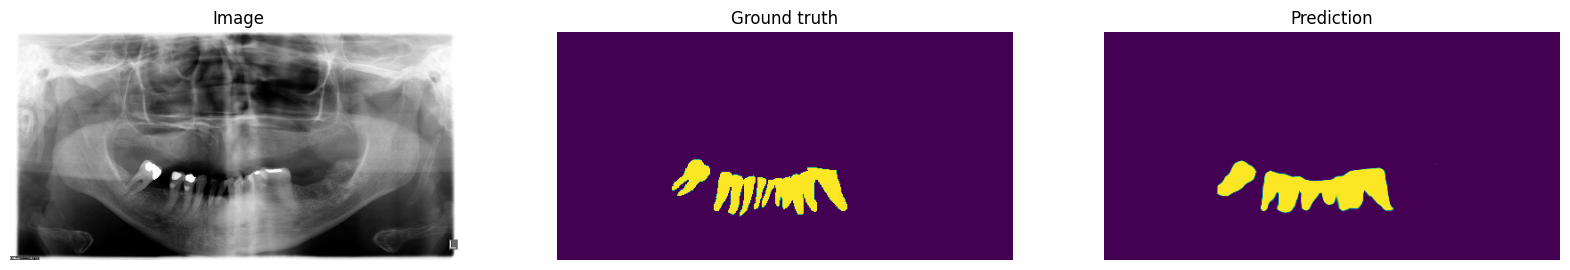

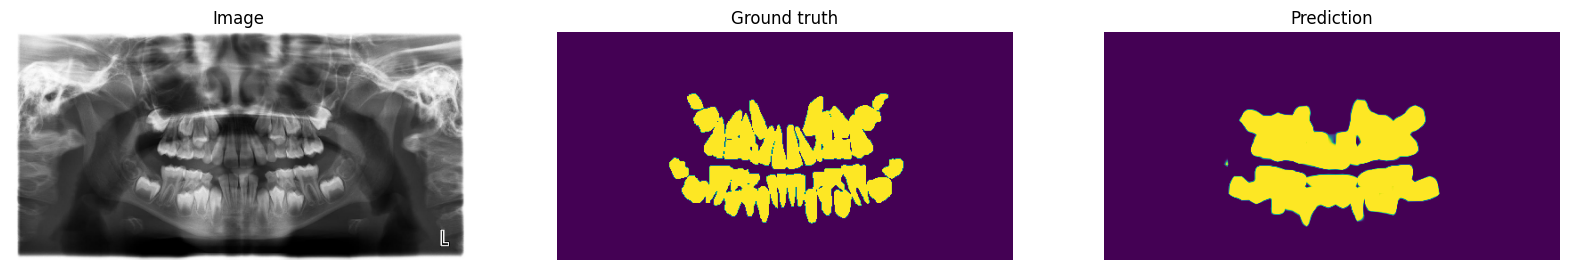

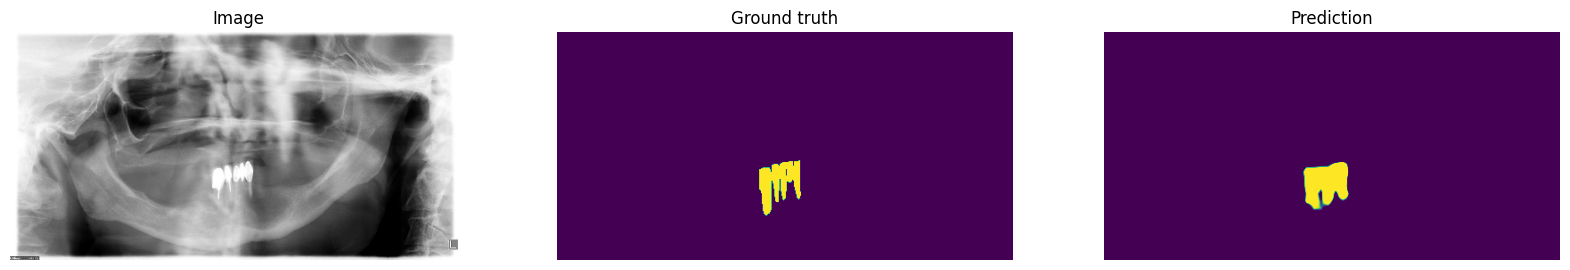

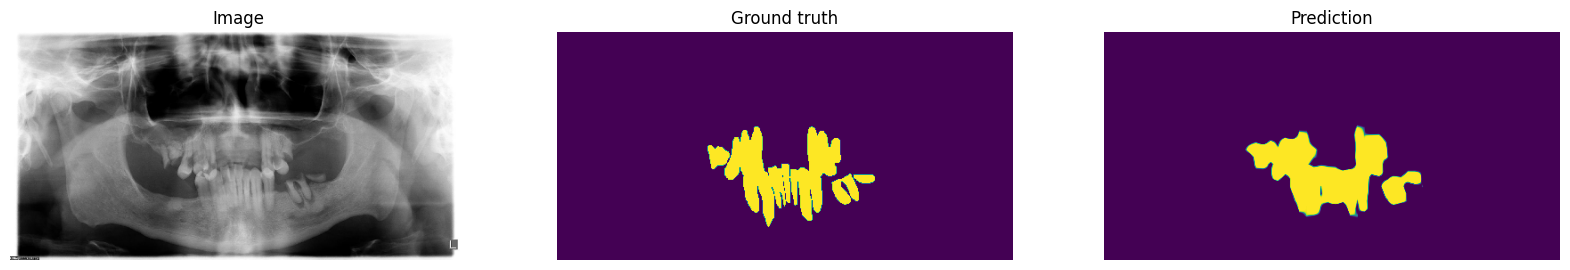

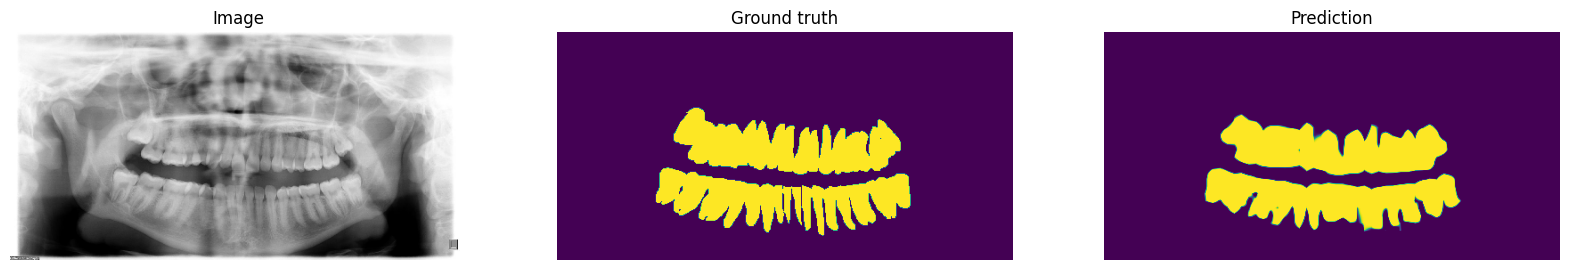

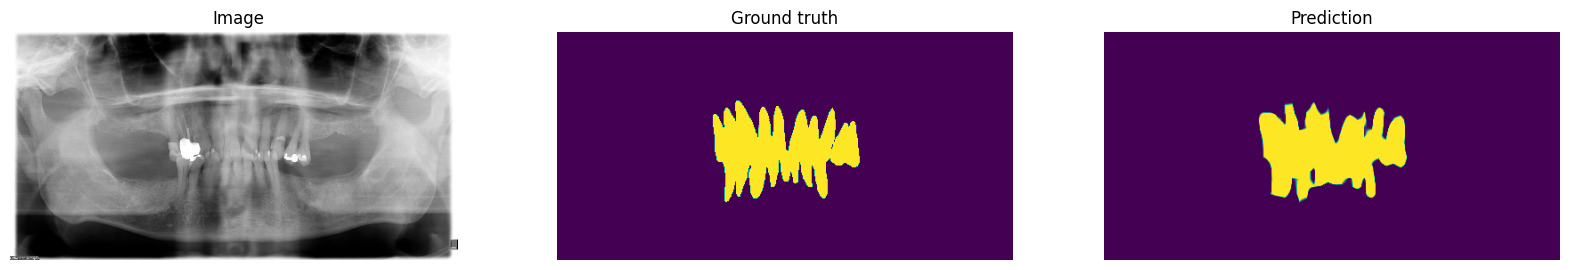

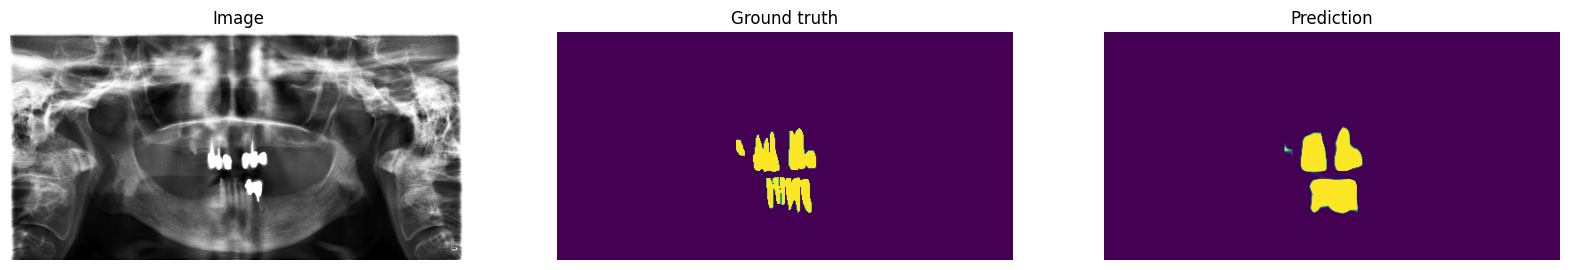

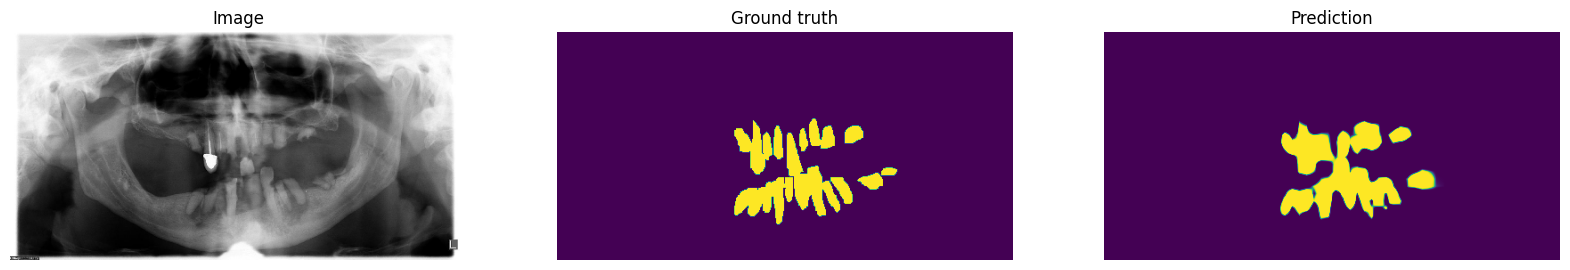

In [ ]:
batch = next(iter(test_dataloader))


image, mask = batch

with torch.inference_mode():
    model.eval()
    logits = model(image)
pr_masks = logits.sigmoid()


for image, gt_mask, pr_mask in zip(image, mask, pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
# Disconnect the Colab session after training
import time
time.sleep(5)  # Give some time to save any necessary checkpoints
from google.colab import runtime
runtime.unassign()